# Single Allocation Capacitated Facility Location Problem.
### Autor: Saúl Sosa Díaz
---
## El problema.
El Single Allocation Capacitated Facility Location Problem (SACFLP) es una compleja problemática dentro de la investigación operativa y logística, enfocada en la asignación óptima de clientes a instalaciones, bajo la premisa de capacidades limitadas y la minimización de costos. Su objetivo es la selección estratégica de ubicaciones para instalar estas facilidades, asignando a cada cliente a una única instalación, de manera que se reduzcan tanto los costos de establecimiento como los operativos. Las restricciones de capacidad son cruciales, ya que cada instalación tiene un límite máximo que no debe sobrepasarse, asegurando que la demanda de los clientes asignados no exceda esta capacidad.

El SACFLP implica costos de dos índoles: el de instalación, referente a la apertura y mantenimiento de la facilidad, y el de transporte, vinculado al servicio a los clientes desde las instalaciones asignadas. Este último usualmente varía según la distancia o el tiempo de viaje entre las instalaciones y los clientes. Su relevancia se extiende a diversas áreas, como la planificación de redes de distribución, ubicación de almacenes, y centros de distribución, así como en la planificación de infraestructuras de servicios.

Por tanto, se tiene un grupo $I$ de $n$ clientes y otro grupo $J$ de $m$ ubicaciones potenciales para fábricas. Cada cliente, designado como $i$ en el grupo $I$, tiene una demanda especificada $d_i$. En paralelo, cada fábrica, marcada como $j$ en el conjunto $J$, conlleva un costo asociado $f_j$ y una capacidad máxima de producción $q_j$. Además, se conoce el costo $c_{ij}$ de transporte por cada unidad de demanda del cliente $i$ que es atendida por la fábrica $j$.

Teniendo estos datos el problema se podría modelar de la siguiente manera.

**Variables**
 
 * $x_{ij}$ es una variable continua que representa la cantidad de demanda del cliente $i$ satisfecha por la fábrica $j$. $\forall i \in I \land \forall j \in J$
 * $z_{ij}$ es una variable binaria que representa si el cliente $i$, está servido por la fábrica $j$. $\forall i \in I \land \forall j \in J$
 * $y_j$ es una variable binaria que representa si la fábrica $j$ ha sido abierta, siendo 1 este indicativo. $\forall j \in J$      

**Función objetivo**
Formalmente, se busca:
$$
    \begin{array}{ccc}
        &\min \sum_{j \in J}f_j y_j + \sum_{i \in I}\sum_{j \in J} c_{ij} x_{ij}
    \end{array}
$$

sujeto a:
$$
    \begin{array}{ccc} &\\ 
        &  x_{ij} = d_i z_{ij}   & \forall  i \in I \land  \forall j \in J \\
        & \sum_{i \in I} x_{ij} \leq q_j y_j & \forall  j \in J  \\
        &   x_{ij} \leq d_i y_j             & \forall i \in I  \land  \forall j \in J \\
        & \sum_{j \in J} z_{ij} = 1 & \forall  i \in I  \\
        & x_{ij} \geq 0                    & \forall  i \in I \land  \forall j \in J \\
        & y_j \in \{ 0,1 \}                & \forall  j \in J \\
        & z_{ij} \in \{ 0,1 \}                & \forall  i \in I \land  \forall j \in J
    \end{array}
$$


## Resolución del problema.
Importamos los paquetes necesarios.

In [1]:
import Pkg
Pkg.add("JuMP")
Pkg.add("GLPK")
Pkg.add("Plots")


using JuMP, GLPK, Random, Plots, Random, LinearAlgebra



    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.9/Project.toml`
  No Changes to `~/.julia/environments/v1.9/Manifest.toml`


### Introducimos los datos.

In [39]:
n = 5    # number of factory locations
m = 20   # number of clients

Random.seed!(5678)

Xf, Yf = rand(0:100,n), rand(0:100,n)   # Factory potential locations
Xc, Yc = rand(0:100,m), rand(0:100,m)   # Clients' locations
factory_location = [Xf,Yf]
client_location  = [Xc,Yc]
cost   = zeros(Float32,n,m)  # cost per unit from factory to customer
for i=1:n, j=1:m
    cost[i, j] = round(sqrt( (Xf[i] - Xc[j])^2 +(Yf[i] - Yc[j])^2 ),digits=0)
end

fixed  = rand(20:30 , n)     # Fixed costs on facilities
supply = rand(15:20, n)      # supply for facilities
demand = rand(1:5, m)        # demands for customers

if sum(supply)<sum(demand)
    println(" Hay poca disponibilidad en los almacenes y demasiada demanda en los clientes!!!")
    println(" disponibilidad=",sum(supply)," demand=",sum(demand) )
    p = sum(supply)/sum(demand)   # an alternative to produce a feasible problem may be to reduce the served demand!
    demand = floor(demand/p)
end

Preparamos la representación de los datos.

In [40]:
function DrawInstance(client_location,factory_location,supply,demand)
    Xc = client_location[1]
    Yc = client_location[2]
    Xf = factory_location[1]
    Yf = factory_location[2]
    p = scatter( # Plot the clients
        Xc,
        Yc;
        label = nothing,
        markershape = :circle,
        markercolor = :green,
        markersize = 2 .* (2 .+ demand)
    )
    scatter!( # Plot the factories
        Xf,
        Yf;
        label = nothing,
        markershape = :star5,
        markercolor = :yellow,
        markersize = supply,
        markerstrokewidth = 2,
    )
    # Adjust the axis limits
    delta_x = 0.1 * (maximum(Xc) - minimum(Xc))
    delta_y = 0.1 * (maximum(Yc) - minimum(Yc))  
    xlims!(minimum(Xc) - delta_x, maximum(Xc) + delta_x)
    ylims!(minimum(Yc) - delta_y, maximum(Yc) + delta_y)

    display(p)
end

function DrawSolution(x,y)
    scatter(
        Xc,
        Yc;
        label = nothing,
        markershape = :circle,
        markercolor = :blue,
        markersize = 2 .* (2 .+ demand),
    )

    scatter!(
        Xf,
        Yf;
        label = nothing,
        markershape = :square,
        markercolor = [(y[i] > 0.001 ? :red : :white) for i in 1:n],
        markersize = supply,
        markerstrokecolor = :red,
        markerstrokewidth = 2,
    )

    for i in 1:n, j in 1:m
        if x[i, j] > 1e-5
            plot!(
                [Xf[i], Xc[j]],
                [Yf[i], Yc[j]];
                color = ( x[i,j] < demand[j] - 0.001 ? :black : :green ),
                label = nothing,
            )
        end
    end
end

DrawSolution (generic function with 1 method)

Mostramos el mapa visualmente. Donde las estrellas representan la ubicación de nuestras fábricas y los cículos representan nuestros clientes. Es importante recalcar que el tamaño de estos puntos son respectivos a sus suministros y a su demanda respectivamente.

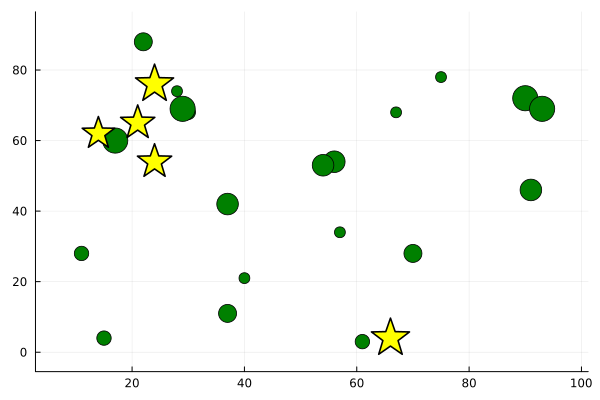

In [41]:
DrawInstance(client_location,factory_location,supply,demand)

### Construir el modelo.

In [16]:
function CuttingPlane(model,x)
    while true
        optimize!(model)
        xval = JuMP.value.(x)
        G = Graphs.SimpleDiGraph( Graphs.Edge.([ (i,j) for i=1:N,j=1:N if xval[i,j]>0.5 ]) )
        Components = Graphs.connected_components(G)
        if length(Components)==1
            break
        end
        @constraint(model, [S in Components], sum(x[S,S]) <= length(S)-1 )
    end
end
    
function SolveTSPTWcut()
    EPS = 0.00001
    model = Model(GLPK.Optimizer)
    set_silent(model)

    # Variables
    @variable(model, x[1:N,1:N], Bin)
    for i in 1:N
            set_upper_bound(x[i,i], 0)
    end
    @variable(model, u[2:N]>=0 )

    @objective(model, Min, sum(C .* x))
    # Normal TSP constraints
    @constraint(model, [i=1:N], sum(x[i,:]) == 1)
    @constraint(model, [i=1:N], sum(x[:,i]) == 1)
    @constraint(model, [i=1:N,j=i+1:N], x[i,j]+x[j,i] <= 1)

    M = maximum(L) # Big M
   
    # Time window constraints
    for i=2:N
        @constraint(model, E[i] <= u[i] <= L[i])
    end
    for i=2:N,j=2:N
        if i!=j
            @constraint(model, u[j] >= u[i] + s[i] + T[i,j] * x[i,j] - M * (1-x[i,j]) )
        end
    end
    

    # Dinamic constraints
    CuttingPlane(model,x)

    # Show solutions
    PlotGraph(N,value.(x), E, L, Names)
    println("Optval: $( ceil(objective_value(model)-EPS) )")
    
    PrintTour(N, value.(x), Names)
end

SolveTSPTWcut (generic function with 1 method)

Resolvemos y mostramos el resultado.

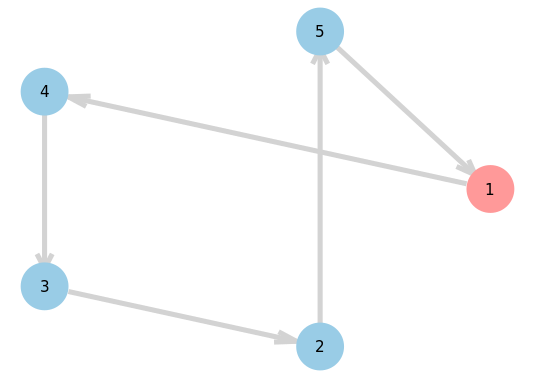

1. Restaurant at the End of the Universe: (0.0-6.40)
2. Planet Squornshellous Zeta: (2.30-3.40)
3. Trillia: (1.10-2.45)
4. Brontitall: (1.10-2.30)
5. Kakrafoon: (2.20-6.0)

Optval: 435.0
Tour: Restaurant at the End of the Universe => Brontitall => Trillia => Planet Squornshellous Zeta => Kakrafoon


In [17]:
SolveTSPTWcut()

La ruta que debería seguir Arthur es la siguiente:
 * Restaurante del fin del mundo => Brontitall => Trillia => Planet Squornshellous Zeta => Kakrafoon

### Ahora comprobaremos que es un camino diferente al que genera el TSP.

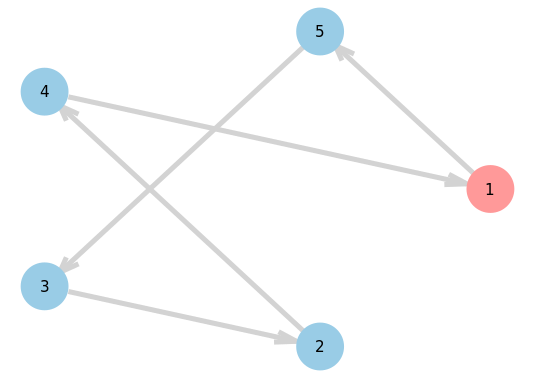

1. Restaurant at the End of the Universe: (0.0-6.40)
2. Planet Squornshellous Zeta: (2.30-3.40)
3. Trillia: (1.10-2.45)
4. Brontitall: (1.10-2.30)
5. Kakrafoon: (2.20-6.0)

Optval: 423.0
Tour: Restaurant at the End of the Universe => Kakrafoon => Trillia => Planet Squornshellous Zeta => Brontitall


In [18]:
function SolveTSP()
    EPS = 0.00001
    model = Model(GLPK.Optimizer)
    set_silent(model)

    # Variables
    @variable(model, x[1:N,1:N], Bin)
    for i in 1:N
            set_upper_bound(x[i,i], 0)
    end

    @objective(model, Min, sum(C .* x))
    # Normal TSP constraints
    @constraint(model, [i=1:N], sum(x[i,:]) == 1)
    @constraint(model, [i=1:N], sum(x[:,i]) == 1)
    @constraint(model, [i=1:N,j=i+1:N], x[i,j]+x[j,i] <= 1)

    # Dinamic constraints
    CuttingPlane(model,x)

    # Show solutions
    PlotGraph(N,value.(x), E, L, Names)
    println("Optval: $( ceil(objective_value(model)-EPS) )")
    
    PrintTour(N, value.(x), Names)
end

SolveTSP()

Vemos que el camino es diferente, y además, su solución tiene un valor menor, lo cual es lógico al tratarse de un problema relajado del problema del viajante de comercio con ventana de tiempo.